In [51]:
# Import Statements

# MacOS Environment
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Standard Imports
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import re

# Machine Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Embedding, Dense, Dropout, GlobalAveragePooling1D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Layer, Embedding
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Warnings
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

In [52]:
# Check Version, GPU Devices
print('Tensorflow Version:', tf.__version__)
tf.config.list_physical_devices('GPU')

Tensorflow Version: 2.14.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [53]:
# Set Specific (Unused) GPU
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1], 'GPU')

In [54]:
# Load Datasets
dataset = 'Dataset/training.1600000.processed.noemoticon.csv'
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Read Dataset
data = pd.read_csv(dataset, encoding = 'ISO-8859-1', names = column_names)

# Displaying Head
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [55]:
# Clean Text Regex
def clean_text(text):

    # Remove Mentions, URL
    text = re.sub(r'(@[A-Za-z0-9_]+)|(\w+:\/\/\S+)', ' ', text)

    # Remove Special Characters, Numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert To Lower Case
    text = text.lower().strip()

    # Return Cleaned Text
    return text

# Apply Cleaning Function To Text Column
data['clean_text'] = data['text'].apply(clean_text)

# Explore Target Column
target_counts = data['target'].value_counts()

# Display First Few Rows Of Cleaned Text, Target Distribution
clean_text_head = data[['clean_text', 'target']].head()
target_counts, clean_text_head

(target
 0    800000
 4    800000
 Name: count, dtype: int64,
                                           clean_text  target
 0  awww thats a bummer  you shoulda got david car...       0
 1  is upset that he cant update his facebook by t...       0
 2  i dived many times for the ball managed to sav...       0
 3     my whole body feels itchy and like its on fire       0
 4  no its not behaving at all im mad why am i her...       0)

In [56]:
# Check Text Lengths, Other Statistics
text_lengths = data['clean_text'].apply(lambda x: len(x.split()))
print(text_lengths.describe().apply(lambda x: '{:.1f}'.format(x)))
char_lengths = data['clean_text'].apply(lambda x: len(x))
print(char_lengths.describe().apply(lambda x: '{:.1f}'.format(x)))

count    1600000.0
mean          12.4
std            6.8
min            0.0
25%            7.0
50%           11.0
75%           18.0
max           40.0
Name: clean_text, dtype: object
count    1600000.0
mean          62.6
std           34.3
min            0.0
25%           34.0
50%           58.0
75%           90.0
max          179.0
Name: clean_text, dtype: object


In [57]:
# Encode Labels: Convert 4 -> 1 For Positive Sentiment
data['target_encoded'] = data['target'].apply(lambda x: 1 if x == 4 else 0)

# Split Data Into Features 
features = data['clean_text']
labels = data['target_encoded']

# Perform 80 / 20 Train Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

# Check Shapes
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((1280000,), (320000,), (1280000,), (320000,))

In [58]:
# Setting Maximum Sequence Length
NUM_TOP_WORDS = None
MAX_ART_LEN = 180
NUM_CLASSES = 2

# Initialize, Fit Tokenizer
tokenizer = Tokenizer(num_words = NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Convert Text To Sequence, Padding
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(train_sequences, maxlen = MAX_ART_LEN)
X_test = pad_sequences(test_sequences, maxlen = MAX_ART_LEN)

In [59]:
# Preparing GloVe Embedding
glove_file = 'Dataset/glove.6B.100d.txt'
embeddings_index = {}
with open(glove_file, 'r', encoding = 'utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs

print('Found %s Word Vectors.' % len(embeddings_index))

# Create Embedding Matrix
found_words = 0
EMBED_SIZE = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        found_words = found_words + 1

# Print Embedding Information
print("Embedding Shape:", embedding_matrix.shape,
      "\nTotal Words Found:", found_words,
      "\nPercentage:", 100 * found_words / embedding_matrix.shape[0])

# Check Shapes Of Padded Train Test Data
X_train.shape, X_test.shape, embedding_matrix.shape

Found 400000 Word Vectors.
Embedding Shape: (361091, 100) 
Total Words Found: 87363 
Percentage: 24.194178198847382


((1280000, 180), (320000, 180), (361091, 100))

In [60]:
# Save Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights = [embedding_matrix],
                            input_length = MAX_ART_LEN,
                            trainable = False)

In [61]:
# CONVOLUTIONAL

In [62]:
# Add Positional Encoding For Transformer
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()

        # Embedding For Processing Tokens, Pretrained (Words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights = [embedding_matrix],
                            input_length = MAX_ART_LEN,
                            trainable = False)
        
        # Embedding For Processing Position
        self.pos_emb = Embedding(MAX_ART_LEN, 
                                 EMBED_SIZE, 
                                 input_length = MAX_ART_LEN,
                                 trainable = True
                                )

    # Layer Definition
    def call(self, x):

        # Create Static Position measure
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start = 0, limit = maxlen, delta = 1)

        # Embed Positions, Tokens, Add Embeddings
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [63]:
# Transformer Architecture
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.2):
        super().__init__()

        # Setup Model Heads, FFN
        self.att = MultiHeadAttention(num_heads = num_heads, 
                                      key_dim = embed_dim)

        # Make Two Layer Network For Attn Processing
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation = 'relu') )
        self.ffn.add( Dense(embed_dim) )
        
        # Add Layer Normalization, Dropout
        self.layernorm1 = LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = LayerNormalization(epsilon = 1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):

        # Get Attention Output From Multi Heads (Self Attn)
        attn_output = self.att(inputs, inputs)
        
        # Create Residual Output W/ Attn
        out1 = self.layernorm1(inputs + attn_output)
        
        # Apply Dropout If Training
        out1 = self.dropout1(out1, training = training)
        
        # Place Through FFN After LayerNorm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)

        # Apply Dropout If Training
        out2 = self.dropout2(out2, training = training)

        # Return Residual From Dense Layer
        return out2

In [64]:
# No. Attemntion heads
num_heads = 4

# Hidden Layer Size FFN
ff_dim = 32

# Define Model
inputs = Input(shape = (MAX_ART_LEN,))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.4)(x)

# Output Layer For Binary Classification
preds = Dense(1, activation = 'sigmoid')(x)

# Print Model
model_xformer20 = Model(inputs = inputs, outputs = preds)
print(model_xformer20.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180)]             0         
                                                                 
 glove_token_and_position_e  (None, 180, 100)          36127100  
 mbedding_3 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_2 (Trans  (None, 180, 100)          168232    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_3  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_15 (Dropout)        (None, 100)               0   

In [68]:
# Compile Transformer Architecture
model_xformer20.compile(loss = 'binary_crossentropy', 
                        optimizer = 'adam',
                        metrics = ['accuracy'])
histories = []
tmp = model_xformer20.fit(X_train, y_train, 
                          validation_data = (X_test, y_test),
                          epochs = 6, batch_size = 256)
histories.append(tmp)

Epoch 1/6
5000/5000 [==============================] - 95s 18ms/step - loss: 0.5162 - accuracy: 0.7464 - val_loss: 0.5333 - val_accuracy: 0.7299
Epoch 2/6
4640/5000 [==========================>...] - ETA: 6s - loss: 0.5654 - accuracy: 0.7070

KeyboardInterrupt: 

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=EMBED_SIZE, 
                    weights=[embedding_matrix], 
                    input_length=MAX_ART_LEN, 
                    trainable=False))

# Bidirectional LSTM or GRU
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
tmp = model.fit(X_train, y_train, 
                          validation_data = (X_test, y_test),
                          epochs = 6, batch_size = 256)

Epoch 1/6
5000/5000 [==============================] - 185s 36ms/step - loss: 0.4782 - accuracy: 0.7715 - val_loss: 0.4413 - val_accuracy: 0.7936
Epoch 2/6
5000/5000 [==============================] - 177s 35ms/step - loss: 0.4315 - accuracy: 0.8015 - val_loss: 0.4146 - val_accuracy: 0.8083
Epoch 3/6
5000/5000 [==============================] - 177s 35ms/step - loss: 0.4142 - accuracy: 0.8117 - val_loss: 0.4068 - val_accuracy: 0.8139
Epoch 4/6
5000/5000 [==============================] - 177s 35ms/step - loss: 0.4037 - accuracy: 0.8176 - val_loss: 0.4050 - val_accuracy: 0.8178
Epoch 5/6
5000/5000 [==============================] - 177s 35ms/step - loss: 0.3962 - accuracy: 0.8220 - val_loss: 0.4025 - val_accuracy: 0.8179
Epoch 6/6
 523/5000 [==>...........................] - ETA: 2:23 - loss: 0.3899 - accuracy: 0.8247

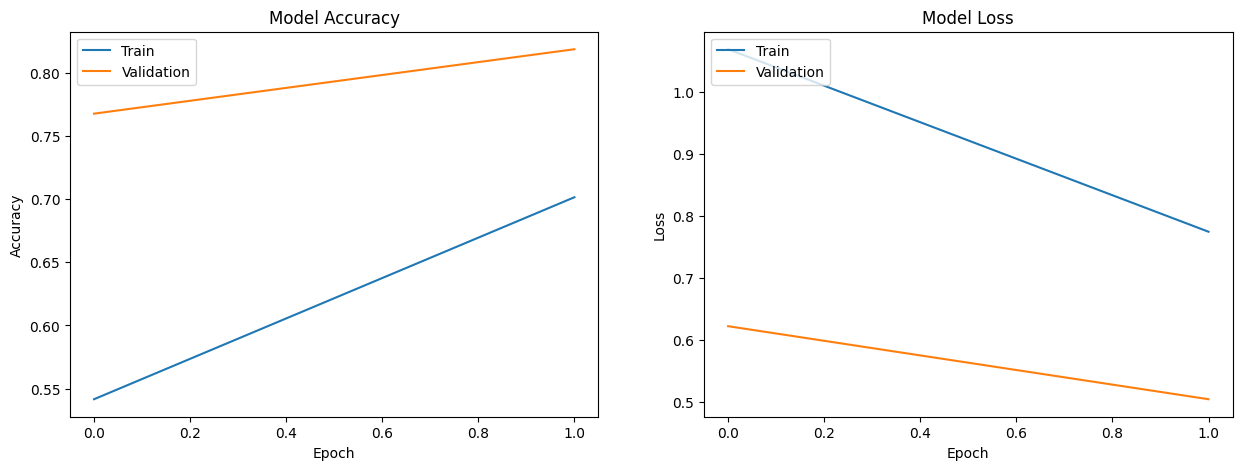

In [23]:
from matplotlib import pyplot as plt

# Assuming 'history' is the history object returned by the fit method of your model

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# **BERT Exceptional Credit**

In [22]:
# Load Datasets
training_data_path = 'Dataset/twitter_training.csv'
validation_data_path = 'Dataset/twitter_validation.csv'
training_data = pd.read_csv(training_data_path)
validation_data = pd.read_csv(validation_data_path)
NUM_CLASSES = 3

# Combine Datasets
combined_data = pd.concat([training_data, validation_data])

# Separate Features Targets
tweets = combined_data.iloc[:, 3]
labels = combined_data.iloc[:, 2]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)

In [24]:
# Initialize WordPiece Tokenizer, Bert Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Stringify
X_train_str = X_train.astype(str).tolist()
X_test_str = X_test.astype(str).tolist()

# Tokenize
train_encodings = tokenizer(X_train_str, truncation = True, padding = 'max_length', max_length = 280, return_tensors = "tf")
test_encodings = tokenizer(X_test_str, truncation = True, padding = 'max_length', max_length = 280, return_tensors = "tf")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [25]:
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

ValueError: invalid literal for int() with base 10: 'Neutral'

In [20]:
# Input Layer
input_ids = tf.keras.layers.Input(shape = (280,), dtype = tf.int32, name = "input_ids")
attention_masks = tf.keras.layers.Input(shape = (280,), dtype = tf.int32, name = "attention_masks")

# BERT Layer
bert_output = bert_model(input_ids, attention_mask=attention_masks)[1]  # We use the pooled output

# Additional layers
x = tf.keras.layers.Dense(64, activation='relu')(bert_output)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)  # num_classes is the number of your target classes

# Build the model
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
history = model.fit(
    {'input_ids': train_encodings['input_ids'], 'attention_masks': train_encodings['attention_mask']},
    y_train,  # Your prepared labels
    validation_data=(
        {'input_ids': test_encodings['input_ids'], 'attention_masks': test_encodings['attention_mask']},
        y_test
    ),
    epochs=3,
    batch_size=32
)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).